# Handling Imbalanced Data

In [2]:
# importing libraries

import pandas as pd
import numpy as np
import tensorflow as tf
import os
# for some models GPU capacity was not enough hence trained those models by disabling GPU with below line
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
from tensorflow.keras.layers import Dense,Flatten,Embedding,Concatenate
from tensorflow.keras.layers import Conv1D,MaxPooling1D,Dropout,Conv2D,MaxPooling2D
from tensorflow.keras.layers import Input,Activation,LSTM,BatchNormalization
from tensorflow.keras.models import Model
from sklearn.preprocessing import Normalizer
from sklearn.metrics import roc_curve,roc_auc_score,f1_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm
from sklearn.preprocessing import minmax_scale,MinMaxScaler
import tensorflow_text as text
import pathlib
import tensorflow_addons as tfa

In [3]:
# reading preprocessed data

structured_data = pickle.load(open("structured_data.pkl","rb"))
print("Shape of created dataframe is : ",structured_data.shape)
print("Shape of created featrure matrix in feat_mat column is : ",structured_data['feat_mat'].values[1].shape)

Shape of created dataframe is :  (10956, 6)
Shape of created featrure matrix in feat_mat column is :  (500, 310, 1)


In [4]:
# for missing data for any company, on a particular day, was assigned 0 as sign change label
# hence removing those to have cleaned data
# structured_data = structured_data[structured_data.sign_change != 0]


# changing -1 & 1 to 0 & 1 to have binary crossentropy as loss and sigmoid as final layer activation.
# structured_data['sign_change'] = structured_data.sign_change.apply(lambda x:0 if x==-1 else 1)

structured_data = structured_data.sort_values(by=['post_date','company_name'])

structured_data['tweet_text_len'] = structured_data.tweet_text.apply(lambda x:len(x.split()))

structured_data.head()

,post_date,tweet_text,company_name,feat_mat,change_label,sign_change,tweet_text_len
0,2015-01-01,aapl store line sapporo japan lucky bag pic ht...,AAPL,"[[[0.0031695721077654], [0.0020060180541624], ...",0.0,1,501
1826,2015-01-01,aapl store line sapporo japan lucky bag pic ht...,AMZN,"[[[0.0031695721077654], [0.0020060180541624], ...",0.0,1,501
9130,2015-01-01,aapl store line sapporo japan lucky bag pic ht...,GOOG,"[[[0.0031695721077654], [0.0020060180541624], ...",0.0,1,501
3652,2015-01-01,aapl store line sapporo japan lucky bag pic ht...,GOOGL,"[[[0.0031695721077654], [0.0020060180541624], ...",0.0,1,501
7304,2015-01-01,aapl store line sapporo japan lucky bag pic ht...,MSFT,"[[[0.0031695721077654], [0.0020060180541624], ...",0.0,1,501


In [5]:
# the data that we have is from '2015-01-01' to '2019-12-31'
# Hence taking last 6 months as test data and 4 years, 6 months of training data from the dataset
train_data = structured_data[structured_data.post_date < '2019-06-01']
test_data = structured_data[structured_data.post_date >= '2019-06-01']


# getting train data for all models
# two class labels are there, one is magnitude of % change
# while second one is sign of change (values 0 or 1 : 0 - negative change, 1 - positive change)
y_train_change = train_data['change_label'].values
y_train_sign = train_data['sign_change'].values
y_train_sign = y_train_sign.astype('int')
x_train_text = train_data['tweet_text'].values
x_train_feat = list(train_data['feat_mat'].values)
x_train_feat = np.array(x_train_feat)
x_train_company = train_data['company_name'].values

# getting test data for all models
y_test_change = test_data['change_label'].values
y_test_sign = test_data['sign_change'].values
y_test_sign = y_test_sign.astype('int')
x_test_text = test_data['tweet_text'].values
x_test_feat = list(test_data['feat_mat'].values)
x_test_feat = np.array(x_test_feat)
x_test_company = test_data['company_name'].values

print("Number of data points in train data are :",train_data.shape[0])
print("Number of data points in train data are :",test_data.shape[0])

Number of data points in train data are : 9672
Number of data points in train data are : 1284


In [7]:
# referred below link to implement subword tokenizer
# https://www.tensorflow.org/text/guide/subwords_tokenizer

bert_tokenizer_params=dict(lower_case=True)
reserved_tokens=[]

bert_vocab_args = dict(
    # The target vocabulary size
    vocab_size = 8000,
    # Reserved tokens that must be included in the vocabulary
    reserved_tokens=reserved_tokens,
    # Arguments for `text.BertTokenizer`
    bert_tokenizer_params=bert_tokenizer_params,
    # Arguments for `wordpiece_vocab.wordpiece_tokenizer_learner_lib.learn`
    learn_params={},
)

# creating BertTokenizer object with vocab text file genrated as per reference link stated above
en_tokenizer = text.BertTokenizer('en_vocab.txt', **bert_tokenizer_params)
vocab_size_text = len(pathlib.Path('en_vocab.txt').read_text().splitlines())+ 1


# Using BertTokenizer to tokenize train data
encoded_text = en_tokenizer.tokenize(x_train_text)
encoded_text = encoded_text.merge_dims(-2,-1)   # reducing dimension of ragged tensor
encoded_text = encoded_text.to_list()           # converting to list to pad the sequences
max_length = 5000                               # max length of padding
train_text = pad_sequences(encoded_text, maxlen=max_length, padding='post')


# Using BertTokenizer to tokenize test data 
encoded_text = en_tokenizer.tokenize(x_test_text)
encoded_text = encoded_text.merge_dims(-2,-1)
encoded_text = encoded_text.to_list()
test_text = pad_sequences(encoded_text, maxlen=max_length, padding='post')


# saving tokenizer output so that there won't be any need to recalculate this for every execution
# pickle.dump([vocab_size_text,train_text,test_text],open("bert_tokens.pkl","wb"))

In [ ]:
# loading saved tokenizer output

[vocab_size_text,train_text,test_text] = pickle.load(open("bert_tokens.pkl","rb"))

In [9]:
# We don't need to use subwordtokenizer here since these company names are standard
# and these will not be changed while giving as inputs


# creating tokens for company names
tokenizer = Tokenizer()                   # creating tokenizer object
tokenizer.fit_on_texts(x_train_company) 
vocab_size_company = len(tokenizer.word_index) + 1

# getting tokenized train data
train_comp = np.array(tokenizer.texts_to_sequences(x_train_company))

# getting tokenized test data
test_comp = np.array(tokenizer.texts_to_sequences(x_test_company))

#### <li> In Model training notebook, the best model was found to be Multichannel Convolution Network with both feature Matrix and combined tweet text as input. </li>
#### <li> Let us try to train this model by assigning weights to loss function. </li>

## Multichannel Convolution Neural Network Model with both tweet text & feature matrix as inputs and assigning loss weights according to data point numbers

In [10]:
# defining the model

np.random.seed(0)
tf.random.set_seed(0)

# clearing previous session if it exists.
tf.keras.backend.clear_session()

# essay feature
input_text = Input(shape=(5000,),name="Tweet text input")

embedding_text = Embedding(vocab_size_text, 100)(input_text)


conv11 = Conv1D(64,kernel_size = 20,padding='same')(embedding_text)

maxpool11 = MaxPooling1D(10)(conv11)


conv12 = Conv1D(64,kernel_size = 10,padding='same')(embedding_text)

maxpool12 = MaxPooling1D(10)(conv12)


concat1 = Concatenate()([maxpool11,maxpool12])

flatten1 = Flatten()(concat1)



input_feat = Input(shape=(500,310,1),name="feature_matrix input")

conv21 = Conv2D(64,(3,3),padding='same')(input_feat)

pool21 = MaxPooling2D()(conv21)

flatten2 = Flatten()(pool21)



input_company = Input(shape=(1,),name="Company_name")

embedding_company = Embedding(vocab_size_company, 6)(input_company)

flatten3 = Flatten()(embedding_company)



concat = Concatenate()([flatten1,flatten2,flatten3])

dense_layer1 = Dense(50,activation='relu',kernel_initializer=tf.keras.initializers.he_uniform())(concat)

dense_layer2 = Dense(50,activation='relu',kernel_initializer=tf.keras.initializers.he_uniform())(dense_layer1)

dense_layer3 = Dense(50,activation='relu',kernel_initializer=tf.keras.initializers.he_uniform())(dense_layer2)

dense_layer4 = Dense(50,activation='relu',kernel_initializer=tf.keras.initializers.he_uniform())(dense_layer3)

dense_layer41 = Dense(50,activation='relu',kernel_initializer=tf.keras.initializers.he_uniform())(dense_layer4)

dense_layer41 = Dense(50,activation='relu',kernel_initializer=tf.keras.initializers.he_uniform())(dense_layer41)

output_sign = Dense(1,activation = 'sigmoid',name="sign_prediction")(dense_layer41)

dense_layer42 = Dense(50,activation='relu',kernel_initializer=tf.keras.initializers.he_uniform())(dense_layer4)

dense_layer42 = Dense(50,activation='relu',kernel_initializer=tf.keras.initializers.he_uniform())(dense_layer42)

output_change = Dense(1,activation='relu',name="Change_prediction")(dense_layer42)


model = Model(inputs=[input_text,input_feat,input_company]
              ,outputs=[output_change,output_sign])

In [11]:
# Referred and implemented Piece wise Decay using below link
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/PiecewiseConstantDecay


step = tf.Variable(0, trainable=False)   # Variable to store and get step number in training

# some numbers are multiples of 301 cause these are steps per epoch with batch size 32
boundaries = [10,50,100, 602, 903]
values = [1e-6,1e-5, 1e-4, 1e-4, 0.5e-4, 1e-5]
learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries, values)
learn_rate = learning_rate_fn(step)


adamw_opt = tfa.optimizers.AdamW(learning_rate=learn_rate,weight_decay=0.0001)

# referred below link to assign weights
# https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/
weights = len(train_data)/(2*train_data['sign_change'].value_counts())

# compiling with adam optimizer and loss as categorical crossentropy
model.compile(optimizer=adamw_opt,loss_weights=[None,{0:weights[0],1:weights[1]}],
              loss=[tf.keras.losses.mean_squared_error,tf.keras.losses.binary_crossentropy])

<li> With the definition stated above for learning rate scheduler, the LR will vary according to the table given below: </li>
<table>
    <tr> 
        <td> <b> Steps </b> </td>
        <td> <b> Learning rate </b> </td>
    </tr>
    <tr> 
        <td> 0-10 </td>
        <td> 1e-6 </td>
    </tr>
     <tr> 
        <td> 10-50 </td>
        <td> 1e-5 </td>
    </tr>
    <tr> 
        <td> 51-602 </td>
        <td> 1e-4 </td>
    </tr>
    <tr> 
        <td> 603-903 </td>
        <td> 0.5e-4 </td>
    </tr>
    <tr> 
        <td> 904-end </td>
        <td> 1e-5 </td>
    </tr>
</table>
<li> We can observe with this learning rate variation, we can achieve the LR warm up steps and then learning decay with each epoch. The decay was stopped at 1e-5 value since, no update observed beyond this LR value. </li>

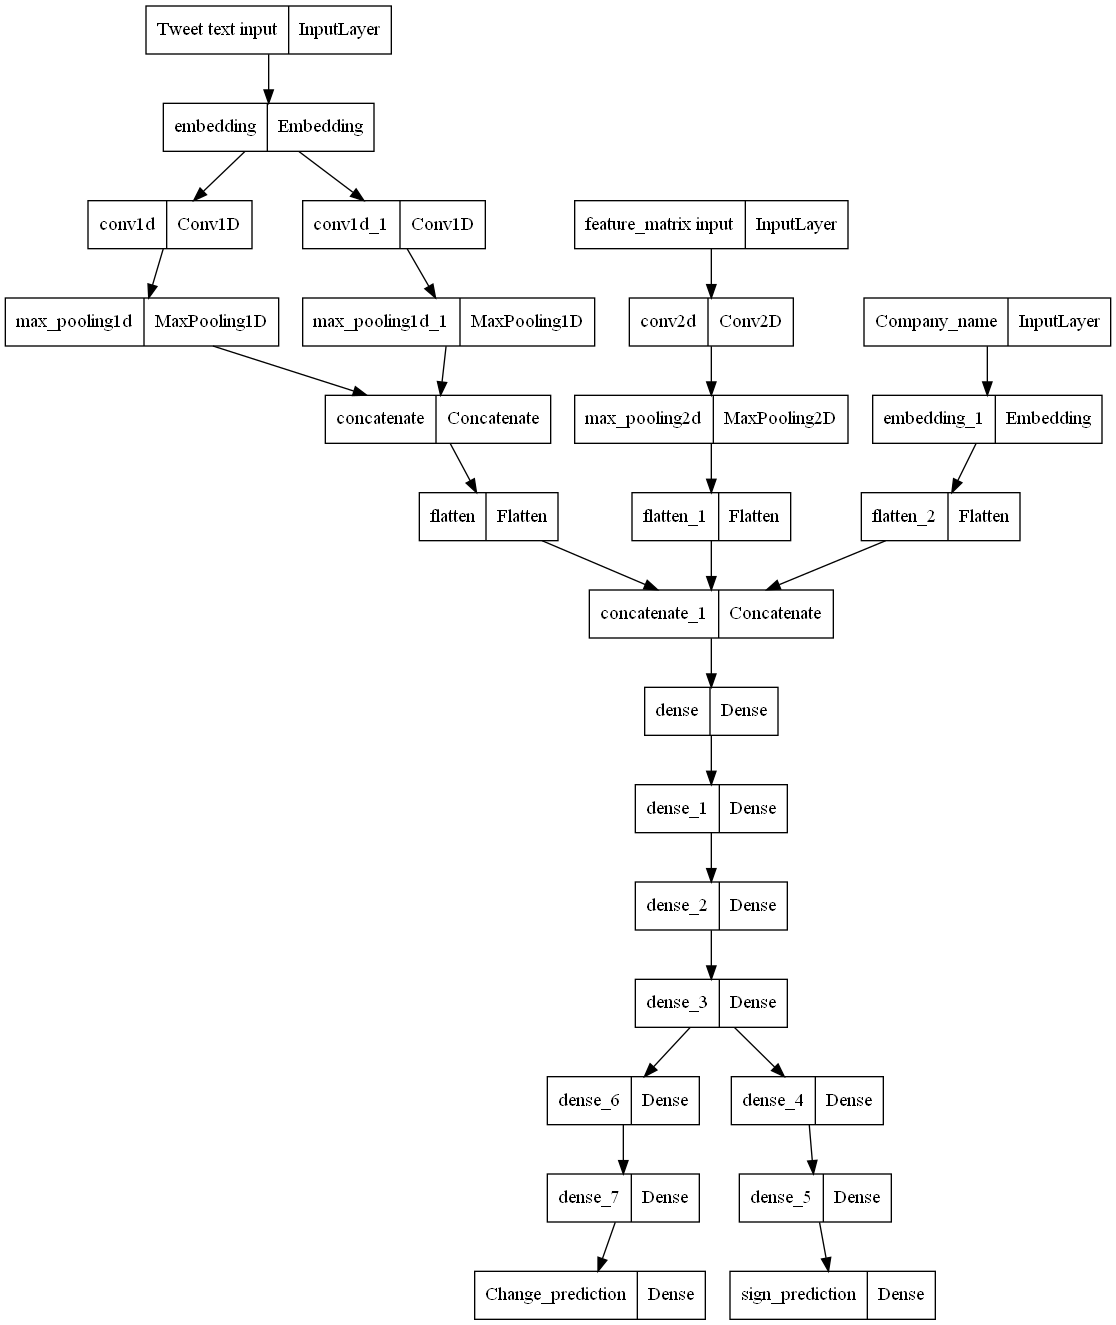

In [12]:
# Plotting model with text input and two outputs
tf.keras.utils.plot_model(model)

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Tweet text input (InputLayer)  [(None, 5000)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 5000, 100)    701100      ['Tweet text input[0][0]']       
                                                                                                  
 conv1d (Conv1D)                (None, 5000, 64)     128064      ['embedding[0][0]']              
                                                                                                  
 conv1d_1 (Conv1D)              (None, 5000, 64)     64064       ['embedding[0][0]']              
                                                                                              

In [12]:
class RecordEpochInformation(tf.keras.callbacks.Callback):
    """
        Accuracy and Loss will recorded with this callback while training
    """
    def on_train_begin(self, logs={}):
            self.loss = []
            self.Change_prediction_loss = []
            self.sign_prediction_loss = []
            self.val_loss = []
            self.val_Change_prediction_loss = []
            self.val_sign_prediction_loss = []
    
    
    def on_epoch_end(self, epoch, logs={}):
        self.loss.append(logs.get('loss'))
        self.Change_prediction_loss.append(logs.get('Change_prediction_loss'))
        self.sign_prediction_loss.append(logs.get('sign_prediction_loss'))
        self.val_loss.append(logs.get('val_loss'))
        self.val_Change_prediction_loss.append(logs.get('val_Change_prediction_loss'))
        self.val_sign_prediction_loss.append(logs.get('val_sign_prediction_loss'))
        
# Creating RecordEpochInformation class object to record info while training
log_info = RecordEpochInformation()

In [13]:
# defining model save callback

from tensorflow.keras.callbacks import ModelCheckpoint

filepath="model_weights/weights-{epoch:02d}-{val_loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss',  verbose=1, save_best_only=True, mode='auto')

In [14]:
# Creating RecordEpochInformation class object to record info while training
log_info = RecordEpochInformation()

model.fit([train_text,x_train_feat,train_comp],[y_train_change,y_train_sign],
          epochs=6,validation_data=([test_text,x_test_feat,test_comp],[y_test_change,y_test_sign]),
         callbacks=[log_info,checkpoint])

Epoch 1/6
303/303 [==============================] - ETA: 0s - loss: 2.5063 - Change_prediction_loss: 1.4965 - sign_prediction_loss: 0.6661
Epoch 00001: val_loss improved from inf to 2.74024, saving model to model_weights\weights-01-2.7402.hdf5
303/303 [==============================] - 970s 3s/step - loss: 2.5063 - Change_prediction_loss: 1.4965 - sign_prediction_loss: 0.6661 - val_loss: 2.7402 - val_Change_prediction_loss: 1.7632 - val_sign_prediction_loss: 0.6445
Epoch 2/6
303/303 [==============================] - ETA: 0s - loss: 2.3066 - Change_prediction_loss: 1.3428 - sign_prediction_loss: 0.6357
Epoch 00002: val_loss improved from 2.74024 to 2.54043, saving model to model_weights\weights-02-2.5404.hdf5
303/303 [==============================] - 961s 3s/step - loss: 2.3066 - Change_prediction_loss: 1.3428 - sign_prediction_loss: 0.6357 - val_loss: 2.5404 - val_Change_prediction_loss: 1.5982 - val_sign_prediction_loss: 0.6216
Epoch 3/6
303/303 [==============================] - E

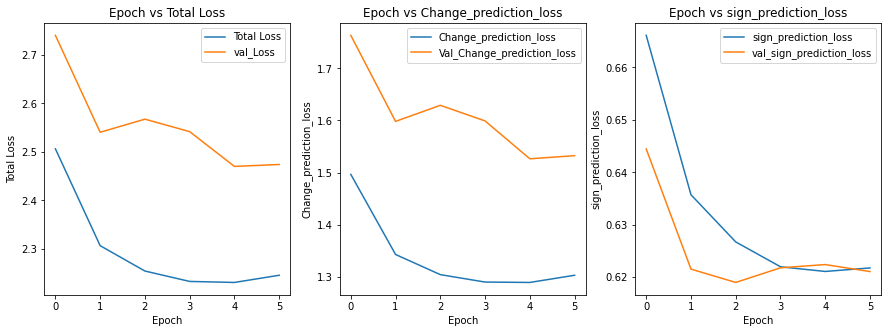

In [15]:
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.plot(log_info.loss,label='Total Loss')
plt.plot(log_info.val_loss,label='val_Loss')
plt.xlabel("Epoch")
plt.ylabel("Total Loss")
plt.title("Epoch vs Total Loss")
plt.legend()

plt.subplot(132)
plt.plot(log_info.Change_prediction_loss,label='Change_prediction_loss')
plt.plot(log_info.val_Change_prediction_loss,label='Val_Change_prediction_loss')
plt.xlabel("Epoch")
plt.ylabel("Change_prediction_loss")
plt.title("Epoch vs Change_prediction_loss")
plt.legend()

plt.subplot(133)
plt.plot(log_info.sign_prediction_loss,label='sign_prediction_loss')
plt.plot(log_info.val_sign_prediction_loss,label='val_sign_prediction_loss')
plt.xlabel("Epoch")
plt.ylabel("sign_prediction_loss")
plt.title("Epoch vs sign_prediction_loss")
plt.legend()

plt.show()

In [14]:
model.load_weights("model_weights\weights-05-2.4700.hdf5")

prediction = model.predict([test_text,x_test_feat,test_comp])

deviation = []
for i in range(len(prediction[0])):
    deviation.append(abs(prediction[0][i]-y_test_change[i]))
print("Mean Deviation for % change in closing prices is : ",np.mean(deviation))

count = 0
sign_pred = [1 if i[0]>=0.5 else 0 for i in prediction[1]]
for i in range(0,len(prediction[1])):
    if sign_pred[i] == y_test_sign[i]:
        count += 1
        
print("Number of correct signs predicted out of {} are : {}".format(len(y_test_sign),count))

Mean Deviation for % change in closing prices is :  0.8439542
Number of correct signs predicted out of 1284 are : 890


In [15]:
# saving tokenizer output so that there won't be any need to recalculate this for every execution
pickle.dump([tokenizer],open("saved_tokenizer_model.pkl","wb"))
model.save("trained_model.h5")

In [43]:
from tensorflow.keras.models import load_model
model = load_model("trained_model.h5")

### Performance Analysis

#### <li> There are two predictions from model and those are chnage prediction and sign_prediction. </li>
#### <li> Let us analyze model performance with respect to each output. </li>

### 1. Change_value_prediction

<li> Let us first analyze the percentile values for deviation from actual values. </li>

In [16]:
deviation = np.array(deviation)

for i in range(0,100,10):
    print("{}th percentile value for deviation is : {}".format(i,np.percentile(deviation,i)))

0th percentile value for deviation is : 0.0025255680084228516
10th percentile value for deviation is : 0.20468310117721558
20th percentile value for deviation is : 0.3622809648513794
30th percentile value for deviation is : 0.5078783452510833
40th percentile value for deviation is : 0.6134413719177246
50th percentile value for deviation is : 0.7499048411846161
60th percentile value for deviation is : 0.8472624540328979
70th percentile value for deviation is : 0.9795998036861417
80th percentile value for deviation is : 1.1228309631347657
90th percentile value for deviation is : 1.3288654088974


<li> Based on the percentile values, let us set a threshold as follows: </li>
<table>
    <tr> 
        <td><b>Category</b></td>
        <td><b>Deviation Value</b></td>
    </tr>
    <tr>
        <td> Best </td>
        <td> <= 0.40 </td>
    </tr>
    <tr>
        <td> Medium </td>
        <td> 0.40 > & <= 1.10  </td>
    </tr>
    <tr>
        <td> Worst </td>
        <td> >= 1.10 </td>
    </tr>
</table>

In [17]:
best_indices = []  # empty list to store best prediction indices in test data
medium_indices = []  # empty list to store medium prediction indices in test data
worst_indices = []  # empty list to store worst prediction indices in test data

# Loop to iterate over all deviations and getting all indices
for i in range(len(deviation)):
    temp = deviation[i]
    if temp <= 0.4:
        best_indices.append(i)
    elif temp > 0.4 and temp <= 1.1:
        medium_indices.append(i)
    else:
        worst_indices.append(i)
        
best_indices = np.array(best_indices)
medium_indices = np.array(medium_indices)
worst_indices = np.array(worst_indices)

best_points = test_data.iloc[best_indices]
medium_points = test_data.iloc[medium_indices]
worst_points = test_data.iloc[worst_indices]

### 1.1 company_name Analysis

In [18]:
print("Number of predictions per Company in best points are : \n",best_points['company_name'].value_counts(),"\n\n")
print("Number of predictions per Company in medium points are : \n",medium_points['company_name'].value_counts(),"\n\n")
print("Number of predictions per Company in worst points are : \n",worst_points['company_name'].value_counts(),"\n\n")

Number of predictions per Company in best points are : 
 AMZN     51
GOOG     50
MSFT     49
GOOGL    48
TSLA     46
AAPL     42
Name: company_name, dtype: int64 


Number of predictions per Company in medium points are : 
 AMZN     124
GOOGL    123
AAPL     123
GOOG     121
MSFT     121
TSLA     105
Name: company_name, dtype: int64 


Number of predictions per Company in worst points are : 
 TSLA     63
AAPL     49
MSFT     44
GOOGL    43
GOOG     43
AMZN     39
Name: company_name, dtype: int64 




<li> We can observe that the number, there is an increase in best predictions although there is no significant change in worst predictions but medium category predictions are shifted to best predictions by assigning loss weights while training. </li>

### 1.2 post_date Analysis

In [19]:
print("best_points start from date {} and end on date {}".format(best_points['post_date'].values[0],best_points['post_date'].values[-1]))
print("medium_points start from date {} and end on date {}".format(medium_points['post_date'].values[0],medium_points['post_date'].values[-1]))
print("worst_points start from date {} and end on date {}".format(worst_points['post_date'].values[0],worst_points['post_date'].values[-1]))

best_points start from date 2019-06-03 and end on date 2019-12-31
medium_points start from date 2019-06-01 and end on date 2019-12-31
worst_points start from date 2019-06-03 and end on date 2019-12-30


<li> Points in all categories are distributed almost complete duration. </li>
<li> Let us analyze this in more detail. </li>

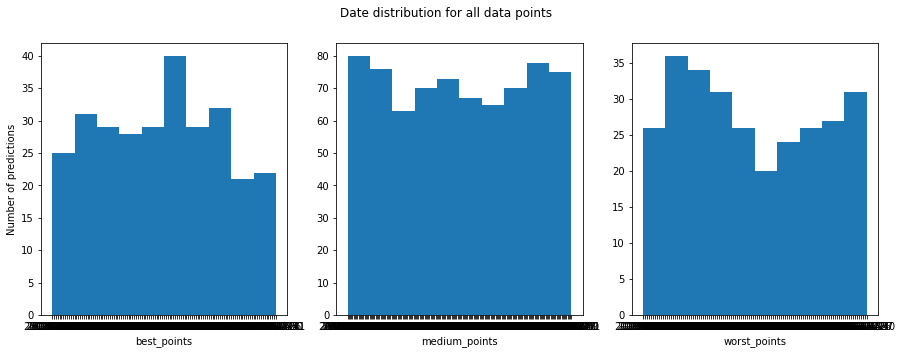

In [20]:
# Plotting date histogram
fig = plt.figure(figsize=(15,5))
fig.suptitle("Date distribution for all data points")
ax1 = fig.add_subplot(1,3,1)
ax1.hist(best_points['post_date'].values)
plt.xlabel("best_points")
plt.ylabel("Number of predictions")


ax2 = fig.add_subplot(1,3,2)
ax2.hist(medium_points['post_date'].values)
plt.xlabel("medium_points")


ax3 = fig.add_subplot(1,3,3)
ax3.hist(worst_points['post_date'].values)
plt.xlabel("worst_points")

plt.show()

<li> With above plots, we can state that number of predictions according to dates are almost similar but for worst points, there are fewer prediction points for some durations. </li>

### 1.3 tweet_text Analysis

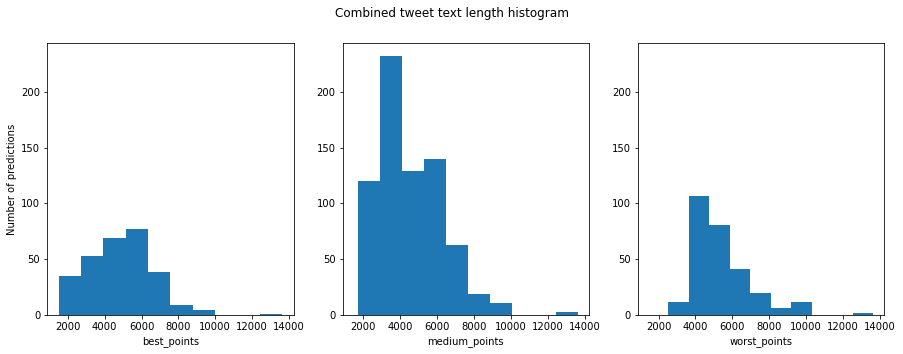

In [21]:
# getting lengths of all combined tweet text data

fig = plt.figure(figsize=(15,5))
fig.suptitle("Combined tweet text length histogram")
ax1 = fig.add_subplot(1,3,1)
ax1.hist([len(i.split()) for i in best_points['tweet_text'].values])
plt.xlabel("best_points")
plt.ylabel("Number of predictions")


ax2 = fig.add_subplot(1,3,2, sharex=ax1, sharey=ax1)
ax2.hist([len(i.split()) for i in medium_points['tweet_text'].values])
plt.xlabel("medium_points")


ax3 = fig.add_subplot(1,3,3, sharex=ax1, sharey=ax1)
ax3.hist([len(i.split()) for i in worst_points['tweet_text'].values])
plt.xlabel("worst_points")

plt.show()

<li> We can observe that the number of data points in all cases are lesser for lower lengths since there aren't many texts with high lenghts. </li>
<li> Also, for lengths lengths lesser than 2000, we are getting best predictions. Below apporx 3000 length, the predictions are best or medium. </li>
<li> With text lengths 0 to 6000, the number of best and medium predictions are more. And beyond 10,000 length, the predictions are worst. </li>

### 1.4 change_label Analysis

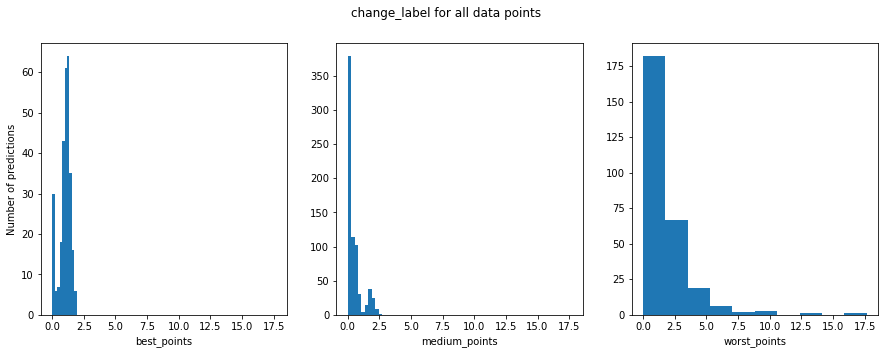

In [22]:
# Plotting date histogram
fig = plt.figure(figsize=(15,5))
fig.suptitle("change_label for all data points")
ax1 = fig.add_subplot(1,3,1)
ax1.hist(best_points['change_label'].values)
plt.xlabel("best_points")
plt.ylabel("Number of predictions")


ax2 = fig.add_subplot(1,3,2, sharex=ax1)
ax2.hist(medium_points['change_label'].values)
plt.xlabel("medium_points")


ax3 = fig.add_subplot(1,3,3, sharex=ax1)
ax3.hist(worst_points['change_label'].values)
plt.xlabel("worst_points")

plt.show()

<li> We can observe that, if the % change is beyond 2.5%, then the predictions are worse. </li>
<li> Also we can observe that that for lower deviation, best and medium points combined are more compared to worst predictions. </li>
<li> It can be concluded that if % change is more, then that change is driven by some major factors other than tweeter and thus the model is performing worst. </li>

### 1.5 sign_change Analysis

#### <li> Here 0 means negative change while 1 means positive change. </li>

In [23]:
print("Number of predictions per Company in best points are : \n",best_points['sign_change'].value_counts(),"\n\n")
print("Number of predictions per Company in medium points are : \n",medium_points['sign_change'].value_counts(),"\n\n")
print("Number of predictions per Company in worst points are : \n",worst_points['sign_change'].value_counts(),"\n\n")

Number of predictions per Company in best points are : 
 1    189
0     97
Name: sign_change, dtype: int64 


Number of predictions per Company in medium points are : 
 1    529
0    188
Name: sign_change, dtype: int64 


Number of predictions per Company in worst points are : 
 1    172
0    109
Name: sign_change, dtype: int64 




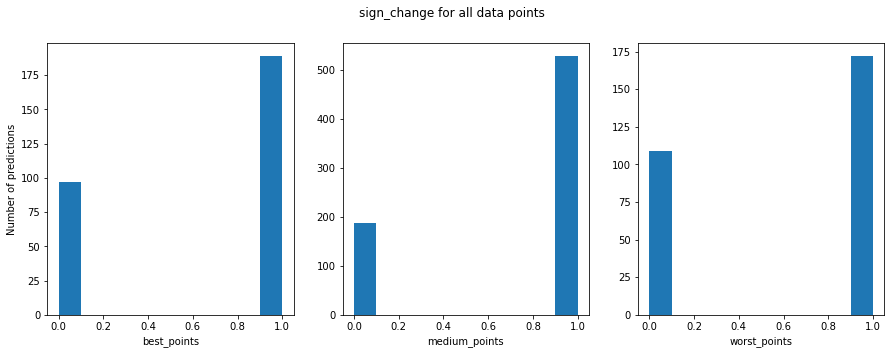

In [24]:
# Plotting date histogram
fig = plt.figure(figsize=(15,5))
fig.suptitle("sign_change for all data points")
ax1 = fig.add_subplot(1,3,1)
ax1.hist(best_points['sign_change'].values)
plt.xlabel("best_points")
plt.ylabel("Number of predictions")


ax2 = fig.add_subplot(1,3,2)
ax2.hist(medium_points['sign_change'].values)
plt.xlabel("medium_points")


ax3 = fig.add_subplot(1,3,3)
ax3.hist(worst_points['sign_change'].values)
plt.xlabel("worst_points")

plt.show()

<li> We can see that the proportion of worst prediction points is more for negative change but if we observe the count, then there is an increase in best & medium predictions when compared to earlier models. </li>

### Conclusion and Oberservations

<li> With weight assignment for loss while training, model was trained to balance with both the classes. </li>
<li> It was observed that there was a reduction in worst prediction data points and also some of the medium prediction data points shifted to best predictions. </li>
<li> Hence weight assignment for loss helped to handle imbalance in sign_change label and improved the output. </li>